<a href="https://colab.research.google.com/github/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/blob/main/Crude_PalmOil_Price_Prediction_using_MLP_Regression_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Load the Required Libraries

In [11]:
import math 
import numpy as np # Python's fundamental package for scientific computing
import pandas as pd # For data analysis and manipulation
from datetime import date, timedelta # Date Operations
import matplotlib.pyplot as plt # To aid in visualizing
import matplotlib.dates as mdates # Date formatting
from sklearn.metrics import mean_absolute_error, mean_squared_error # To assess model performance error computation
from sklearn.preprocessing import MinMaxScaler # to standardize the crude palm oil price data 
from tensorflow.keras.models import Sequential # Deep learning library, that is used in neural networks
#from tensorflow.keras.layers import LSTM, Dense # Deep learning classes for densely linked recurrent and regular layers
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Activation, Dense
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# Establishing a timetable for data extraction
today = date.today()
end_date = today.strftime("%Y-%m")
start_date = '1993-03'

# Getting S&P500 quotes
stockname = 'cpo_pri'

path = '/content/df_cl.csv'
df = read_csv(path, parse_dates=True)

# Examining the dataset's structure
print(df.shape)
df.head(5)

(361, 2)


,date,cpo_pri
0,1993-03,408
1,1993-04,392
2,1993-05,371
3,1993-06,356
4,1993-07,362


In [12]:
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0])) # Selecting only date
df.set_index('date',drop=True,inplace=True) # Setting date column as index
df.head()

,cpo_pri
date,
1993-03-01,408
1993-04-01,392
1993-05-01,371
1993-06-01,356
1993-07-01,362


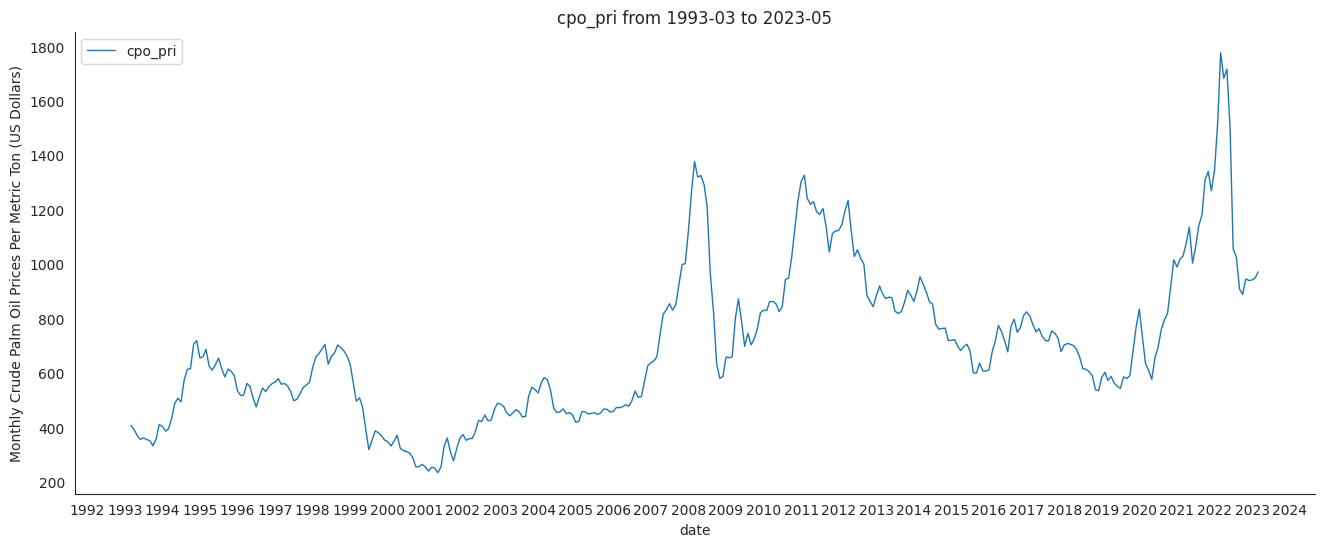

In [13]:
# Constructing a Lineplot
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df['cpo_pri'], label=stockname, linewidth=1.0)
plt.ylabel('Monthly Crude Palm Oil Prices Per Metric Ton (US Dollars)')
plt.show()

In [23]:
# Target Selection 
train_df = df.filter(['cpo_pri'])
data_unsc = train_df.values # data_unscaled data

# Compute the number of rows required to train the model on 80% of the data. 
train_data_len = math.ceil(len(data_unsc) * 0.7)

# Scale each characteristic to a value between 0 and 1 to transform it.
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unsc)

In [24]:
# Set the sequence len - the period for making a single forecast.
sequence_len = 60

# Index of Prediction
index_cpo_pri = train_df.columns.get_loc("cpo_pri")
print(index_cpo_pri)
# Divide the training data into train and train data sets.
# In the first stage, we determine the number of rows required to train the model on 80% of the data. 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Generate training and test data.
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_len:, :]

# The MLP model requires data in the following formats: [samples, time steps, features].
def partition_dataset(sequence_len, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_len, data_len):
        x.append(train_df[i-sequence_len:i,:]) 
        y.append(train_df[i, index_cpo_pri]) 
    
    # Convert the x and y variables to numpy arrays.
    x = np.array(x)
    y = np.array(y)
    return x, y

# Create training and testing data.
X_train, y_train = partition_dataset(sequence_len, train_data)
X_test, y_test = partition_dataset(sequence_len, test_data)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Verify that the prediction value and the input value match
print(X_test[1][sequence_len-1][index_cpo_pri])
print(y_test[0])

0
(229, 60, 1) (229,)
(72, 60, 1) (72,)
0.3357096565132858
0.3357096565132858


In [7]:
'''
# Split the dataset into train and test set
train_size = int(df.shape[0] * 0.67)
train_df, test_df = df.iloc[:train_size, :], df.iloc[train_size:, :]
'''

In [8]:
'''
# Convert an array of values into a dataset matrix
def create_dataset(df, look_back=1):
    m = len(df)
    X = []
    y = []
    for i in range(look_back, m):
        X.append(df[i - look_back: i, 0])
        y.append(df[i, 0])
    return np.array(X), np.array(y)
'''

In [9]:
'''
look_back = 1
X_train, y_train = create_dataset(train_df.values, look_back=look_back)
X_test, y_test = create_dataset(test_df.values, look_back=look_back)
'''

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model = Sequential()
model.add(Dense(8, input_dim=sequence_len, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
115/115 - 1s - loss: 0.1063 - 1s/epoch - 13ms/step
Epoch 2/200
115/115 - 0s - loss: 0.0299 - 158ms/epoch - 1ms/step
Epoch 3/200
115/115 - 0s - loss: 0.0186 - 175ms/epoch - 2ms/step
Epoch 4/200
115/115 - 0s - loss: 0.0118 - 178ms/epoch - 2ms/step
Epoch 5/200
115/115 - 0s - loss: 0.0085 - 156ms/epoch - 1ms/step
Epoch 6/200
115/115 - 0s - loss: 0.0067 - 174ms/epoch - 2ms/step
Epoch 7/200
115/115 - 0s - loss: 0.0059 - 164ms/epoch - 1ms/step
Epoch 8/200
115/115 - 0s - loss: 0.0052 - 162ms/epoch - 1ms/step
Epoch 9/200
115/115 - 0s - loss: 0.0049 - 171ms/epoch - 1ms/step
Epoch 10/200
115/115 - 0s - loss: 0.0045 - 169ms/epoch - 1ms/step
Epoch 11/200
115/115 - 0s - loss: 0.0044 - 165ms/epoch - 1ms/step
Epoch 12/200
115/115 - 0s - loss: 0.0039 - 160ms/epoch - 1ms/step
Epoch 13/200
115/115 - 0s - loss: 0.0036 - 176ms/epoch - 2ms/step
Epoch 14/200
115/115 - 0s - loss: 0.0035 - 168ms/epoch - 1ms/step
Epoch 15/200
115/115 - 0s - loss: 0.0032 - 183ms/epoch - 2ms/step
Epoch 16/200
115/115 

In [30]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=2,verbose=1, callbacks=[callback])

Epoch 1/200
115/115 [==============================] - 1s 6ms/step - loss: 5.6212e-04 - val_loss: 0.0069
Epoch 2/200
115/115 [==============================] - 1s 5ms/step - loss: 4.4198e-04 - val_loss: 0.0053
Epoch 3/200
115/115 [==============================] - 1s 4ms/step - loss: 5.7362e-04 - val_loss: 0.0094
Epoch 4/200
115/115 [==============================] - 0s 4ms/step - loss: 5.8458e-04 - val_loss: 0.0049
Epoch 5/200
115/115 [==============================] - 0s 3ms/step - loss: 5.9347e-04 - val_loss: 0.0059
Epoch 6/200
115/115 [==============================] - 0s 3ms/step - loss: 5.3964e-04 - val_loss: 0.0055
Epoch 7/200
115/115 [==============================] - 0s 3ms/step - loss: 4.3491e-04 - val_loss: 0.0054
Epoch 8/200
115/115 [==============================] - 0s 2ms/step - loss: 4.1236e-04 - val_loss: 0.0047
Epoch 9/200
115/115 [==============================] - 0s 2ms/step - loss: 5.1736e-04 - val_loss: 0.0074
Epoch 10/200
115/115 [==============================] -

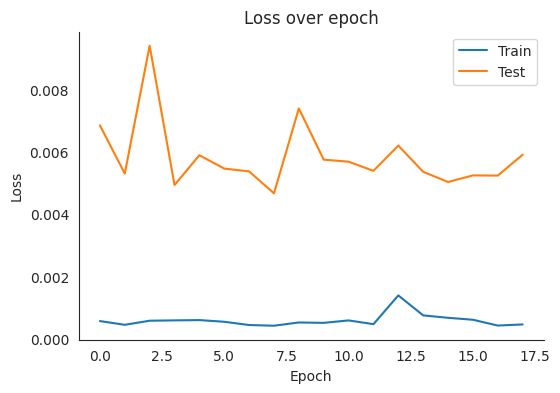

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.title("Loss over epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
# Obtain the predicted values
mlp_pred_scaled = model.predict(X_test)
mlp_pred = mmscaler.inverse_transform(mlp_pred_scaled)
y_test_unsc = mmscaler.inverse_transform(y_test.reshape(-1, 1))

3/3 [==============================] - 0s 5ms/step


In [38]:
# Mean Absolute Error (MAE)
mlp_MAE = mean_absolute_error(y_test_unsc, mlp_pred)
print(f'Median Absolute Error (MAE): {np.round(mlp_MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
mlp_MAPE = np.mean((np.abs(np.subtract(y_test_unsc, mlp_pred)/ y_test_unsc))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(mlp_MAPE, 2)} %')

# Root Mean Squared Error (RMSE)
mlp_RMSE = mean_squared_error(y_test_unsc, mlp_pred) ** 0.5
print(f'Root Mean Squared Error (RMSE): {np.round(mlp_RMSE, 2)} %')

# Mean Squared Error (MSE)
mlp_MSE = mean_squared_error(y_test_unsc, mlp_pred)
print('MSE value of the MLP Model:', mlp_MSE )

# r2_score
mlp_r2 = r2_score(y_test_unsc, mlp_pred)
print(f'R^2 Score: {np.round(mlp_r2, 2)} %')

Median Absolute Error (MAE): 74.82
Mean Absolute Percentage Error (MAPE): 8.05 %
Root Mean Squared Error (RMSE): 105.54 %
MSE value of the MLP Model: 11137.984795524946
R^2 Score: 0.88 %


In [39]:
train = pd.DataFrame(train_df[:train_data_len + 1]).rename(columns={'cpo_pri': 'x_train'})
train

,x_train
date,
1993-03-01,408
1993-04-01,392
1993-05-01,371
1993-06-01,356
1993-07-01,362
...,...
2016-12-01,811
2017-01-01,825
2017-02-01,809


<Axes: title={'center': 'MLP Predictions vs Actual'}, xlabel='date', ylabel='cpo_pri'>

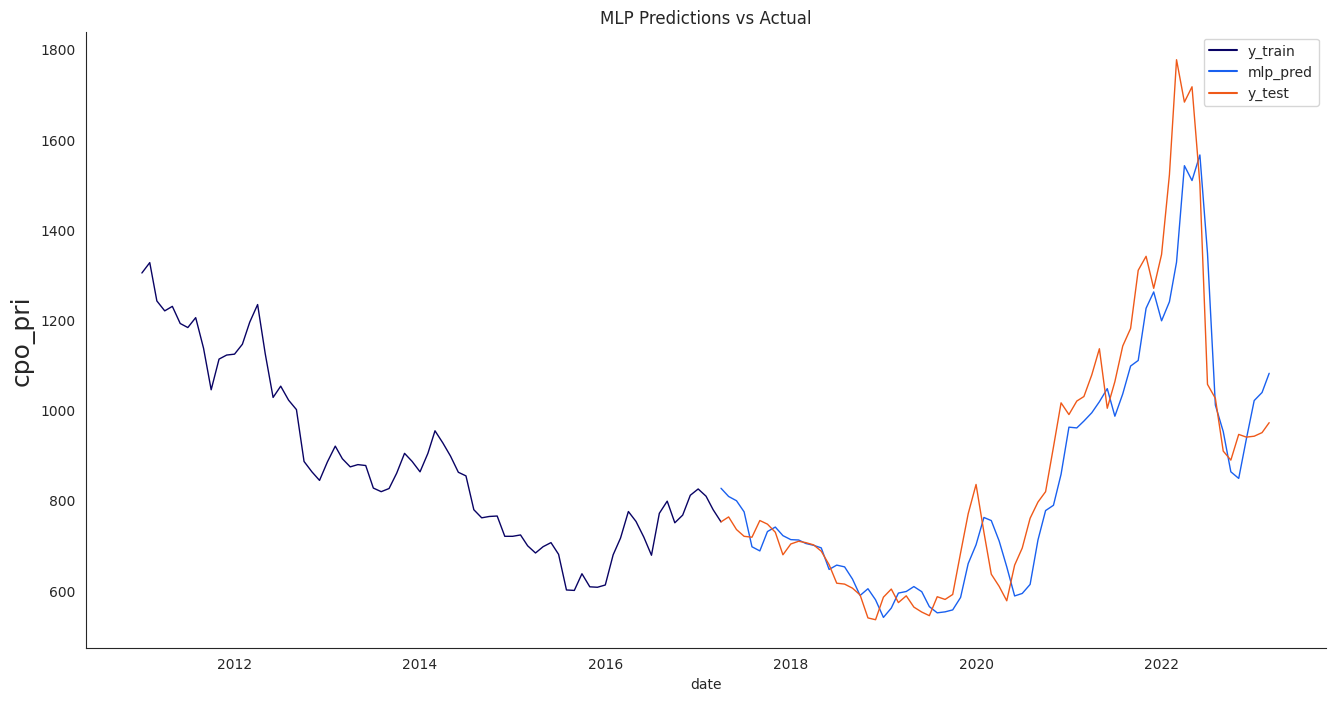

In [41]:
# The date from which on the date is displayed
display_start_date = "2010-12" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df[:train_data_len + 1]).rename(columns={'cpo_pri': 'y_train'})
valid = pd.DataFrame(train_df[train_data_len:]).rename(columns={'cpo_pri': 'y_test'})
valid.insert(1, "mlp_pred", mlp_pred, True)
valid.insert(1, "residuals", valid["mlp_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("MLP Predictions vs Actual")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'mlp_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)